In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_excel("2025-3-15公众号Python机器学习AI.xlsx")
df

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,y
0,1,0,0,0,1,0,0,0,1,0,...,19,550,69,152,1.350,16.90,6.75,6.0,47,1
1,1,0,0,0,1,0,0,1,1,0,...,15,501,74,132,1.490,12.80,4.71,5.8,63,0
2,1,0,0,0,1,0,0,1,1,0,...,20,889,131,141,4.440,15.30,4.26,6.4,48,1
3,0,0,0,0,0,0,0,0,0,0,...,17,18,59,105,1.640,14.40,4.12,5.5,67,0
4,1,0,0,0,1,1,0,0,1,0,...,15,764,72,142,1.210,13.70,3.91,7.0,55,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0,0,0,0,0,0,0,0,0,0,...,25,13,78,134,1.907,0.90,2.04,5.4,69,0
252,0,0,0,0,0,0,0,0,1,0,...,38,3470,90,126,1.075,1.50,2.60,5.5,69,0
253,1,0,0,1,1,1,0,1,0,0,...,27,139,101,154,1.279,1.15,1.83,7.4,51,0
254,0,0,1,0,0,0,0,0,1,0,...,23,1971,85,105,2.730,19.00,3.05,5.8,50,1


In [2]:
from sklearn.model_selection import train_test_split

# 划分特征和目标变量
X = df[['X_9',
 'X_39',
 'X_32',
 'X_34',
 'X_30',
 'X_28',
 'X_46',
 'X_31',
 'X_3',
 'X_36',
 'X_33',
 'X_44',
 'X_16']]
y = df['y']
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=df['y'])

In [3]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# XGBoost模型参数
params_xgb = {
    'random_state': 42,      # 随机种子，用于结果的可重复性
}

# 初始化XGBoost分类模型
model_xgb = XGBClassifier(**params_xgb)

# 定义参数网格，用于网格搜索
param_grid = {
    'n_estimators': [100, 200, 300],  # 树的数量
    'max_depth': [3, 4, 5, 6, 7],                # 树的最大深度
    'learning_rate': [0.1, 0.2],    # 学习率
    'subsample': [0.6, 0.8, 1.0],                # 用于训练的子样本比例
    'colsample_bytree': [0.8, 1.0],        # 每棵树的列采样比例
    'min_child_weight': [1, 2, 3]                # 每个叶子节点的最小权重
}

# 使用GridSearchCV进行网格搜索和k折交叉验证
grid_search = GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='neg_log_loss',  # 评价指标为负对数损失
    cv=5,                    # 5折交叉验证
    n_jobs=-1,               # 并行计算
    verbose=1                # 输出详细进度信息
)

# 训练模型
grid_search.fit(X_train, y_train)

# 输出最优参数
print("Best parameters found: ", grid_search.best_params_)
print("Best Log Loss score: ", -grid_search.best_score_)

# 使用最优参数训练模型
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}
Best Log Loss score:  0.4133584954779028


In [4]:
# 使用最优模型进行预测
y_pred_proba = best_model.predict_proba(X_test)

# 将预测的概率转换为DataFrame
df_pred_proba = pd.DataFrame(y_pred_proba, columns=[f'Class_{i}' for i in range(y_pred_proba.shape[1])])
df_pred_proba.index = X_test.index  # 使用测试集的索引
df_pred_proba.head()

,Class_0,Class_1
194,0.830687,0.169313
4,0.077780,0.922220
76,0.986936,0.013064
183,0.412674,0.587326
157,0.063133,0.936867


In [5]:
df_pred_proba.loc[194]

Class_0    0.830687
Class_1    0.169313
Name: 194, dtype: float32

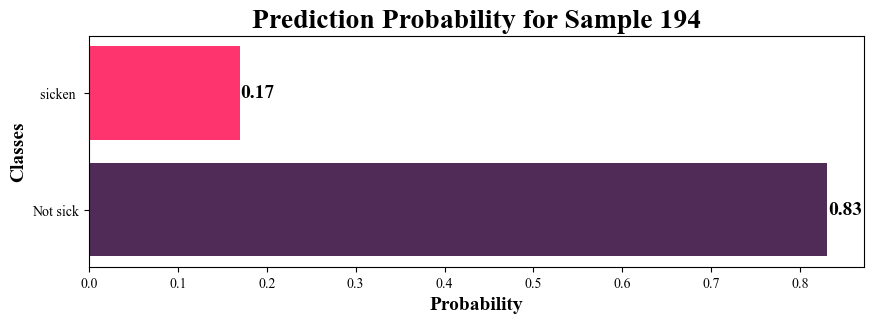

In [6]:
# 获取样本的预测概率
sample_prob = df_pred_proba.loc[194]

# 设置图形的大小
plt.figure(figsize=(10, 3))

# 绘制条形图
bars = plt.barh(['Not sick', 'sicken '], 
                [sample_prob['Class_0'], sample_prob['Class_1']], 
                color=['#512b58', '#fe346e'])

# 添加标题和标签，设置字体加粗并增大字体
plt.title("Prediction Probability for Sample 194", fontsize=20, fontweight='bold')
plt.xlabel("Probability", fontsize=14, fontweight='bold')
plt.ylabel("Classes", fontsize=14, fontweight='bold')

# 添加概率文本标签，并调整文本位置，确保不超出图框，设置字体加粗
for i, v in enumerate([sample_prob['Class_0'], sample_prob['Class_1']]):
    plt.text(v + 0.001, i, f"{v:.2f}", va='center', fontsize=14, color='black', fontweight='bold')
plt.savefig("1.pdf", format='pdf', bbox_inches='tight', dpi=1200)
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_39028\1300434502.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


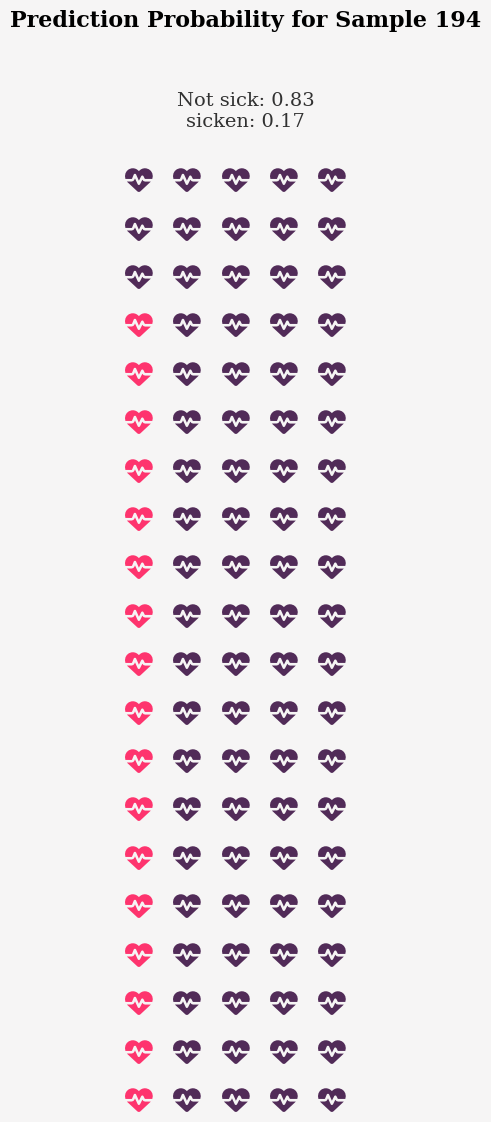

In [9]:
from pywaffle import Waffle

# 获取样本的预测概率
# 假设 df_pred_proba 是包含预测概率的 DataFrame
sample_prob = df_pred_proba.loc[194]  # 获取样本194的预测概率

# 设置 Waffle 图形的参数
fig = plt.figure(FigureClass=Waffle,
                 constrained_layout=True,  # 自动调整布局
                 figsize=(12, 10),  # 设置图形的大小为6x6英寸
                 facecolor='#f6f5f5',  # 设置背景颜色
                 dpi=100,  # 设置每英寸点数
                 plots={  # 设置图表的具体内容
                     111: {  # 代表一个子图（我们这里只有一个子图）
                         'rows': 20,  # 设置Waffle图的行数为5
                         'columns': 5,  # 设置Waffle图的列数为10
                         'values': [sample_prob['Class_0'], sample_prob['Class_1']],  # 设置每个类的占比
                         'colors': ['#512b58', '#fe346e'],  # 设置Class_0和Class_1的颜色
                         'vertical': False,  # 设置是否竖直排列
                         'interval_ratio_x': 0.005,  # 设置水平间隔比例
                         'interval_ratio_y': 0.005,  # 设置垂直间隔比例
                         'icons': 'heartbeat',  # 使用心跳图标来表示每个方格
                         'icon_legend': False,  # 不显示图标图例
                         'icon_size': 20,  # 设置图标的大小
                         'plot_anchor': 'C',  # 图表锚点居中
                         'alpha': 1,  # 设置透明度
                         'starting_location': 'NE'  # 设置起始位置为东北角
                     }
                 })

# 添加标题并居中
fig.text(0.5, 1.1, "Prediction Probability for Sample 194",  # 设置标题文本
         {'font': 'Serif', 'size': 16, 'color': 'black', 'weight': 'bold'}, ha='center')  # 居中显示标题

# 添加预测结果的文本描述，并居中
fig.text(0.5, 1,  # 设置文本的位置
         f"Not sick: {sample_prob['Class_0']:.2f}\nsicken: {sample_prob['Class_1']:.2f}", 
         {'font': 'Serif', 'size': 14, 'color': 'black', 'weight': 'normal'}, alpha=0.8, ha='center')  # 显示Class_0和Class_1的预测概率

plt.savefig("2.pdf", format='pdf', bbox_inches='tight', dpi=1200)
fig.show()